# Parallel Coordinate Plot: Mean Climate, comparing CMIP5 & CMIP6 models

Generate a static image of Parallel coordinate plot for PMP mean climate metrics obtained from CMIP5 and CMIP6 models, and compare multi-model averaged statistics from each group.

Written by Jiwoo Lee (LLNL/PCMDI)

Last update: September 2022

## 1. Read data from JSON files

Input data for parallel coordinate plot is expected as a set a (stacked or list of) 2-d numpy array(s) with list of strings for x and y axes labels. 

### 1.1 Download PMP output JSON files for CMIP models <a name="download"></a>

In [1]:
import glob
import os
import numpy as np
import requests
import pandas as pd
from pcmdi_metrics.graphics import download_archived_results

PMP output files downloadable from the [PMP results archive](https://github.com/PCMDI/pcmdi_metrics_results_archive). 

In [2]:
vars = ['pr', 'prw', 'psl', 'rlds', 'rltcre', 'rlus', 'rlut', 'rlutcs', 'rsds', 'rsdscs', 'rsdt', 'rstcre', 'rsut', 'rsutcs', 'sfcWind', 
        'ta-200', 'ta-850', 'tas', 'tauu', 'ts', 'ua-200', 'ua-850', 'va-200', 'va-850', 'zg-500']

In [3]:
json_dir = './json_files'

In [4]:
mip = "cmip5"
exp = "historical"
data_version = "v20220928"

In [5]:
for var in vars:
    path = "metrics_results/mean_climate/"+mip+"/"+exp+"/"+data_version+"/"+var+"."+mip+"."+exp+".regrid2.2p5x2p5."+data_version+".json"
    download_archived_results(path, json_dir)

In [6]:
mip = "cmip6"
exp = "historical"
data_version = "v20220928"

In [7]:
for var in vars:
    path = "metrics_results/mean_climate/"+mip+"/"+exp+"/"+data_version+"/"+var+"."+mip+"."+exp+".regrid2.2p5x2p5."+data_version+".json"
    download_archived_results(path, json_dir)

Check JSON files

In [8]:
json_list_1 = sorted(glob.glob(os.path.join(json_dir, '*.cmip5.' + exp + '*' + data_version + '.json')))
json_list_2 = sorted(glob.glob(os.path.join(json_dir, '*.cmip6.' + exp + '*' + data_version + '.json')))

In [9]:
print('CMIP5 JSON files:')
for i, json_file in enumerate(json_list_1):
    print(i+1, json_file.split('/')[-1])
    
print('CMIP6 JSON files:')
for i, json_file in enumerate(json_list_2):
    print(i+1, json_file.split('/')[-1])

CMIP5 JSON files:
1 pr.cmip5.historical.regrid2.2p5x2p5.v20220928.json
2 prw.cmip5.historical.regrid2.2p5x2p5.v20220928.json
3 psl.cmip5.historical.regrid2.2p5x2p5.v20220928.json
4 rlds.cmip5.historical.regrid2.2p5x2p5.v20220928.json
5 rltcre.cmip5.historical.regrid2.2p5x2p5.v20220928.json
6 rlus.cmip5.historical.regrid2.2p5x2p5.v20220928.json
7 rlut.cmip5.historical.regrid2.2p5x2p5.v20220928.json
8 rlutcs.cmip5.historical.regrid2.2p5x2p5.v20220928.json
9 rsds.cmip5.historical.regrid2.2p5x2p5.v20220928.json
10 rsdscs.cmip5.historical.regrid2.2p5x2p5.v20220928.json
11 rsdt.cmip5.historical.regrid2.2p5x2p5.v20220928.json
12 rstcre.cmip5.historical.regrid2.2p5x2p5.v20220928.json
13 rsut.cmip5.historical.regrid2.2p5x2p5.v20220928.json
14 rsutcs.cmip5.historical.regrid2.2p5x2p5.v20220928.json
15 sfcWind.cmip5.historical.regrid2.2p5x2p5.v20220928.json
16 ta-200.cmip5.historical.regrid2.2p5x2p5.v20220928.json
17 ta-850.cmip5.historical.regrid2.2p5x2p5.v20220928.json
18 tas.cmip5.historical.re

### 1.2 Extract data from JSON files <a name="extract"></a>

Use `Metrics` class (that use `read_mean_clim_json_files` function underneath) to extract data from the above JSON files.

#### Parameters
- `json_list`: list of string, where each element is for path/file for PMP output JSON files

#### Returned object includes
- `df_dict`: dictionary that has `[stat][season][region]` hierarchy structure storing pandas dataframe for metric numbers (Rows: models, Columns: variables (i.e., 2d array)
- `var_list`: list of string, all variables from JSON files
- `var_unit_list`: list of string, all variables and its units from JSON files
- `var_ref_dict`: dictonary for reference dataset used for each variable
- `regions`: list of string, regions
- `stats`: list of string, statistics

In [10]:
from pcmdi_metrics.graphics import Metrics

In [11]:
library_cmip5 = Metrics(json_list_1, mip="cmip5")

In [12]:
library_cmip6 = Metrics(json_list_2, mip="cmip6")

In [13]:
season = 'ann'
stat = 'rms_xyt'
region = 'global'

## Select only certain models *(optional)*

In [14]:
selected_models = ['ACCESS', 'BCC', 'CESM', 'Can', 'FGOALS', 'FIO-ESM', 'GFDL', 'IPSL', 'MIROC', 'MPI', 'MRI', 'NorESM']


def selected_models_only(df, selected_models):
    # Selected models only
    model_names = df['model'].tolist()
    for model_name in model_names:
        drop_model = True
        for keyword in selected_models:
            if keyword in model_name:
                drop_model = False
                break
        if drop_model:
            df.drop(df.loc[df['model']==model_name].index, inplace=True)
        df.reset_index(drop=True, inplace=True)
    return df


# Selected models only
library_cmip5.df_dict[stat][season][region] = selected_models_only(library_cmip5.df_dict[stat][season][region], selected_models)
library_cmip6.df_dict[stat][season][region] = selected_models_only(library_cmip6.df_dict[stat][season][region], selected_models) 

## Merge data

In [15]:
# merge dataframes
combined = library_cmip5.merge(library_cmip6)

### Add rows of multi-model average statistics for each CMIP group

In [16]:
# mean value of statistics from multi models in each CMIP
combined.df_dict[stat][season][region].loc['CMIP5 mean'] = library_cmip5.df_dict[stat][season][region].mean(numeric_only=True, skipna=True)
combined.df_dict[stat][season][region].loc['CMIP6 mean'] = library_cmip6.df_dict[stat][season][region].mean(numeric_only=True, skipna=True)

combined.df_dict[stat][season][region].at['CMIP5 mean', 'model'] = 'CMIP5 mean'
combined.df_dict[stat][season][region].at['CMIP6 mean', 'model'] = 'CMIP6 mean'

### Customize variables to show

In [17]:
var_list = sorted(combined.var_list)

# temporary
var_list.remove('sfcWind')
var_list.remove('ta-850')
var_list.remove('ua-850')
var_list.remove('ua-200')
var_list.remove('va-850')
var_list.remove('va-200')
var_list.remove('tauu')

print('var_list:', var_list)

var_list: ['pr', 'prw', 'psl', 'rlds', 'rltcre', 'rlus', 'rlut', 'rlutcs', 'rsds', 'rsdscs', 'rsdt', 'rstcre', 'rsut', 'rsutcs', 'ta-200', 'tas', 'ts', 'zg-500']


### Getting ready for plotting...

In [18]:
data = combined.df_dict[stat][season][region][var_list].to_numpy()
model_names = combined.df_dict[stat][season][region]['model'].tolist()
metric_names = var_list
models_to_highlight = ['CMIP5 mean', 'CMIP6 mean']
print('data.shape:', data.shape)
print('len(metric_names): ', len(metric_names))
print('len(model_names): ', len(model_names))

data.shape: (57, 18)
len(metric_names):  18
len(model_names):  57


#### Add unit info

In [19]:
units_all = 'prw [kg m-2], pr [mm d-1], psl [Pa], rlds [W m-2], rsdscs [W m-2], rltcre [W m-2], rlus [W m-2], rlut [W m-2], rlutcs [W m-2], rsds [W m-2], rsdt [W m-2], rstcre [W m-2], rsus [W m-2], rsut [W m-2], rsutcs [W m-2], sfcWind [m s-1], zg-500 [m], ta-200 [K], ta-850 [K], tas [K], ts [K], ua-200 [m s-1], ua-850 [m s-1], uas [m s-1], va-200 [m s-1], va-850 [m s-1], vas [m s-1], tauu [Pa]'
units_all.split(', ')
var_unit_list = [] 

for var in var_list:
    found = False
    for var_units in units_all.split(', '):
        tmp1 = var_units.split(' [')[0]
        #print(var, tmp1)
        if tmp1 == var:
            unit = '[' + var_units.split(' [')[1]
            var_unit_list.append(var + '\n' + unit)
            found = True
            break
    if found is False:
        print(var, 'not found')

print('var_list:', var_list)
print('var_unit_list:', var_unit_list)

metric_names = var_unit_list

var_list: ['pr', 'prw', 'psl', 'rlds', 'rltcre', 'rlus', 'rlut', 'rlutcs', 'rsds', 'rsdscs', 'rsdt', 'rstcre', 'rsut', 'rsutcs', 'ta-200', 'tas', 'ts', 'zg-500']
var_unit_list: ['pr\n[mm d-1]', 'prw\n[kg m-2]', 'psl\n[Pa]', 'rlds\n[W m-2]', 'rltcre\n[W m-2]', 'rlus\n[W m-2]', 'rlut\n[W m-2]', 'rlutcs\n[W m-2]', 'rsds\n[W m-2]', 'rsdscs\n[W m-2]', 'rsdt\n[W m-2]', 'rstcre\n[W m-2]', 'rsut\n[W m-2]', 'rsutcs\n[W m-2]', 'ta-200\n[K]', 'tas\n[K]', 'ts\n[K]', 'zg-500\n[m]']


## 2. Plot

In [20]:
from pcmdi_metrics.graphics import parallel_coordinate_plot

Parameters
----------
- `data`: 2-d numpy array for metrics
- `metric_names`: list, names of metrics for individual vertical axes (axis=1)
- `model_names`: list, name of models for markers/lines (axis=0)
- `models_to_highlight`: list, default=None, List of models to highlight as lines
- `fig`: `matplotlib.figure` instance to which the parallel coordinate plot is plotted.
         If not provided, use current axes or create a new one.  Optional.
- `ax`: `matplotlib.axes.Axes` instance to which the parallel coordinate plot is plotted.
        If not provided, use current axes or create a new one.  Optional.
- `figsize`: tuple (two numbers), default=(15,5), image size
- `show_boxplot`: bool, default=False, show box and wiskers plot
- `show_violin`: bool, default=False, show violin plot
- `violin_colors`: tuple or list containing two strings for colors of violin. Default=("lightgrey", "pink")
- `title`: string, default=None, plot title
- `identify_all_models`: bool, default=True. Show and identify all models using markers
- `xtick_labelsize`: number, fontsize for x-axis tick labels (optional)
- `ytick_labelsize`: number, fontsize for x-axis tick labels (optional)
- `colormap`: string, default='viridis', matplotlib colormap
- `num_color`: integer, default=20, how many color to use.
- `legend_off`: bool, default=False, turn off legend
- `logo_rect`: sequence of float. The dimensions [left, bottom, width, height] of the new Axes.
               All quantities are in fractions of figure width and height.  Optional.
- `logo_off`: bool, default=False, turn off PMP logo
- `model_names2`: list of string, should be a subset of `model_names`.  If given, violin plot will be split into 2 groups. Optional.
- `group1_name`: string, needed for violin plot legend if splited to two groups, for the 1st group. Default is 'group1'.
- `group2_name`: string, needed for violin plot legend if splited to two groups, for the 2nd group. Default is 'group2'.
- `comparing_models`: tuple or list containing two strings for models to compare with colors filled between the two lines.
- `fill_between_lines`: bool, default=False, fill color between lines for models in comparing_models
- `fill_between_lines_colors`: tuple or list containing two strings for colors filled between the two lines. Default=('green', 'red')

Return
------
- `fig`: matplotlib component for figure
- `ax`: matplotlib component for axis

In [21]:
cmip6_models = library_cmip6.df_dict[stat][season][region]['model'].tolist() + ['CMIP6 mean']
cmip6_models

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'CanESM5',
 'CESM2',
 'CESM2-FV2',
 'CESM2-WACCM',
 'CESM2-WACCM-FV2',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'FIO-ESM-2-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'IPSL-CM5A2-INCA',
 'IPSL-CM6A-LR',
 'IPSL-CM6A-LR-INCA',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NorESM2-LM',
 'NorESM2-MM',
 'CMIP6 mean']

Models in the second group: ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'BCC-ESM1', 'CanESM5', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR', 'IPSL-CM6A-LR-INCA', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM', 'NorESM2-MM', 'CMIP6 mean']


Text(0.5, 0.5, 'Example')

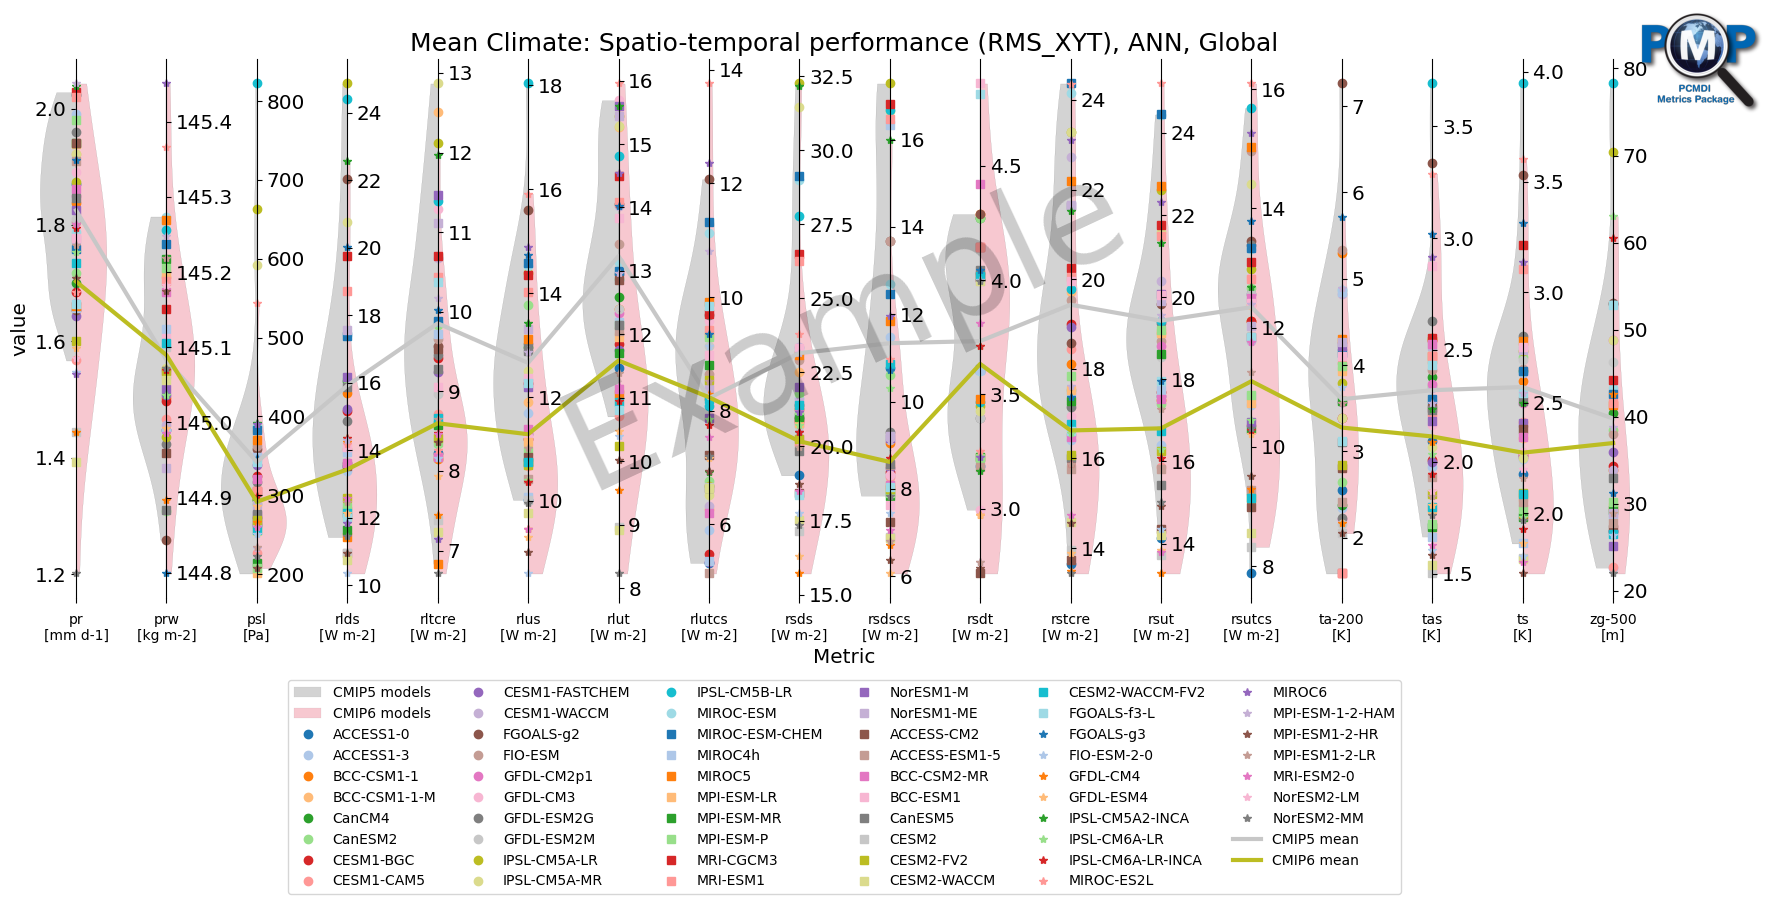

In [22]:
title = 'Mean Climate: Spatio-temporal performance (' + stat.upper() + '), ' + season.upper() + ', ' + region.title()

fig, ax = parallel_coordinate_plot(data, metric_names, model_names, models_to_highlight, 
                                   title=title,
                                   figsize=(21, 7),
                                   colormap='tab20',
                                   xtick_labelsize=10,
                                   logo_rect=[0.8, 0.8, 0.15, 0.15],
                                   show_violin=True,
                                   model_names2=cmip6_models,
                                   group1_name='CMIP5 models',
                                   group2_name='CMIP6 models',  
                                   show_boxplot=False,
                                  )

# Add Watermark
ax.text(0.5, 0.5, 'Example', transform=ax.transAxes,
        fontsize=100, color='black', alpha=0.2,
        ha='center', va='center', rotation=25)

In [23]:
# Save figure as an image file
fig.savefig('mean_clim_parallel_coordinate_plot_cmip56.png', facecolor='w', bbox_inches='tight')

Models in the second group: ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'BCC-ESM1', 'CanESM5', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR', 'IPSL-CM6A-LR-INCA', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM', 'NorESM2-MM', 'CMIP6 mean']


Text(0.5, 0.5, 'Example')

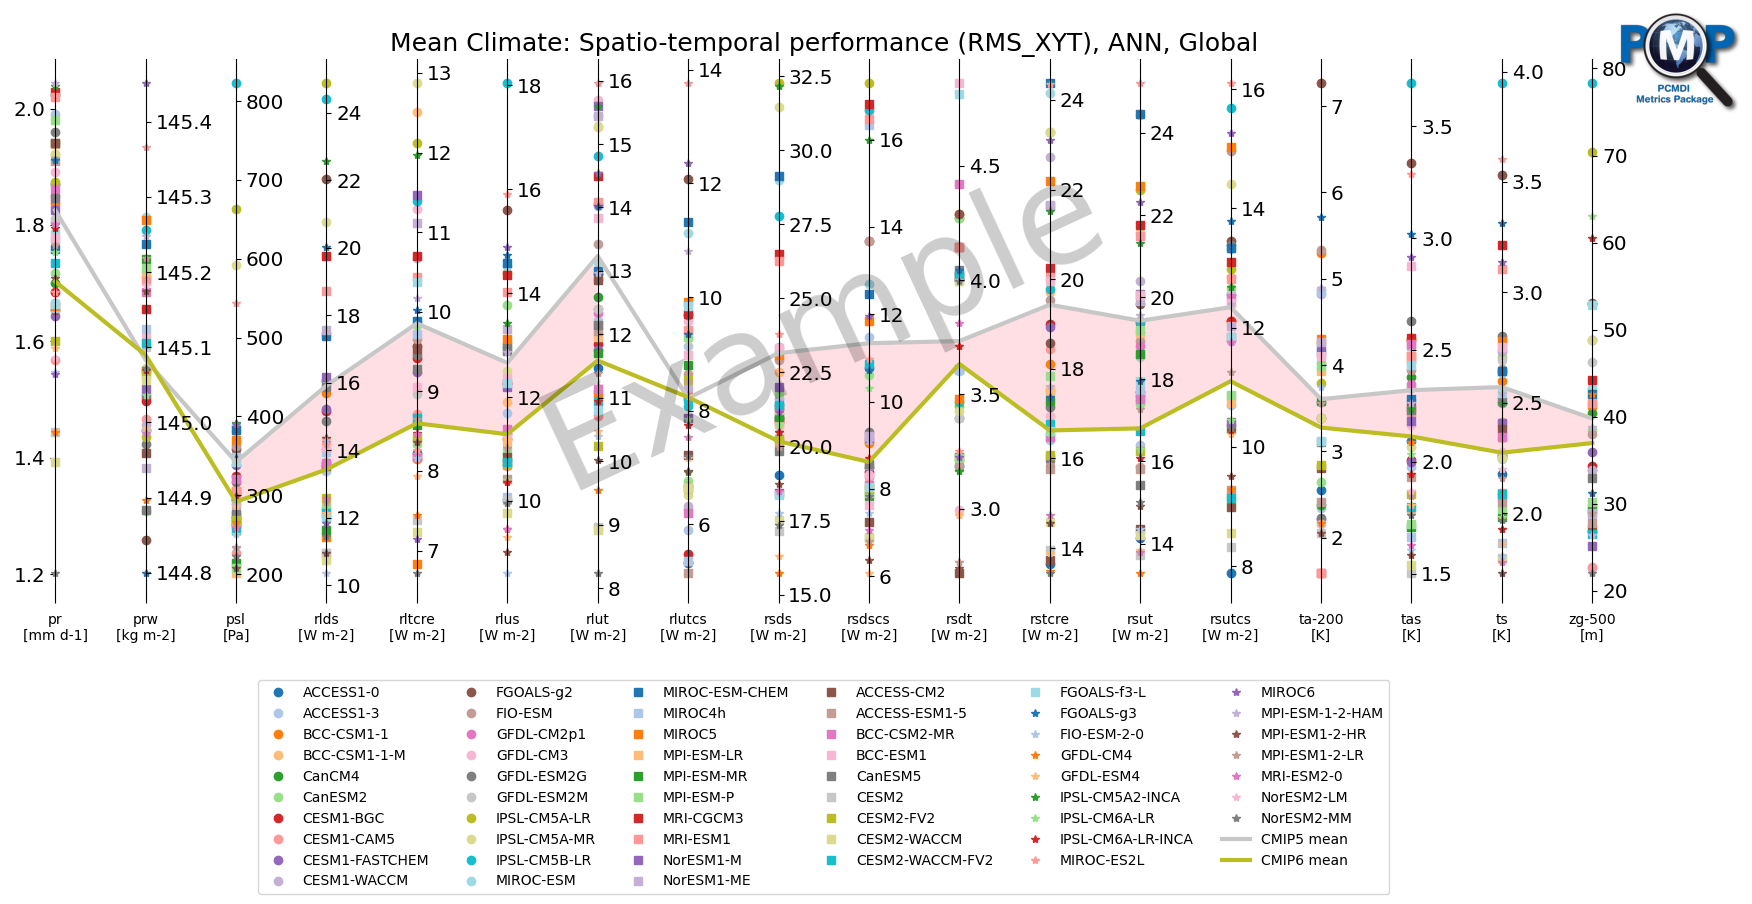

In [24]:
title = 'Mean Climate: Spatio-temporal performance (' + stat.upper() + '), ' + season.upper() + ', ' + region.title()

fig, ax = parallel_coordinate_plot(data, metric_names, model_names, models_to_highlight, 
                                   title=title,
                                   figsize=(21, 7),
                                   colormap='tab20',
                                   xtick_labelsize=10,
                                   logo_rect=[0.8, 0.8, 0.15, 0.15],
                                   show_violin=False,
                                   model_names2=cmip6_models,
                                   group1_name='CMIP5 models',
                                   group2_name='CMIP6 models',  
                                   show_boxplot=False,
                                   comparing_models=('CMIP5 mean', 'CMIP6 mean'),
                                   fill_between_lines=True,
                                   fill_between_lines_colors=('lightgreen', 'pink')
                                  )

# Add Watermark
ax.text(0.5, 0.5, 'Example', transform=ax.transAxes,
        fontsize=100, color='black', alpha=0.2,
        ha='center', va='center', rotation=25)